In [3]:
!pip install rasterio
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.0 MB/s eta 0:00:00


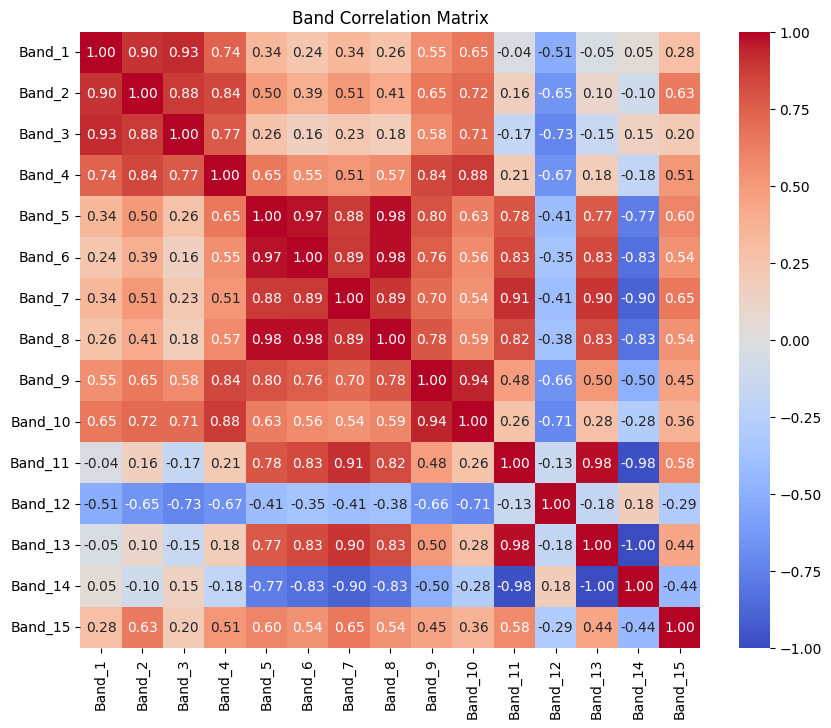

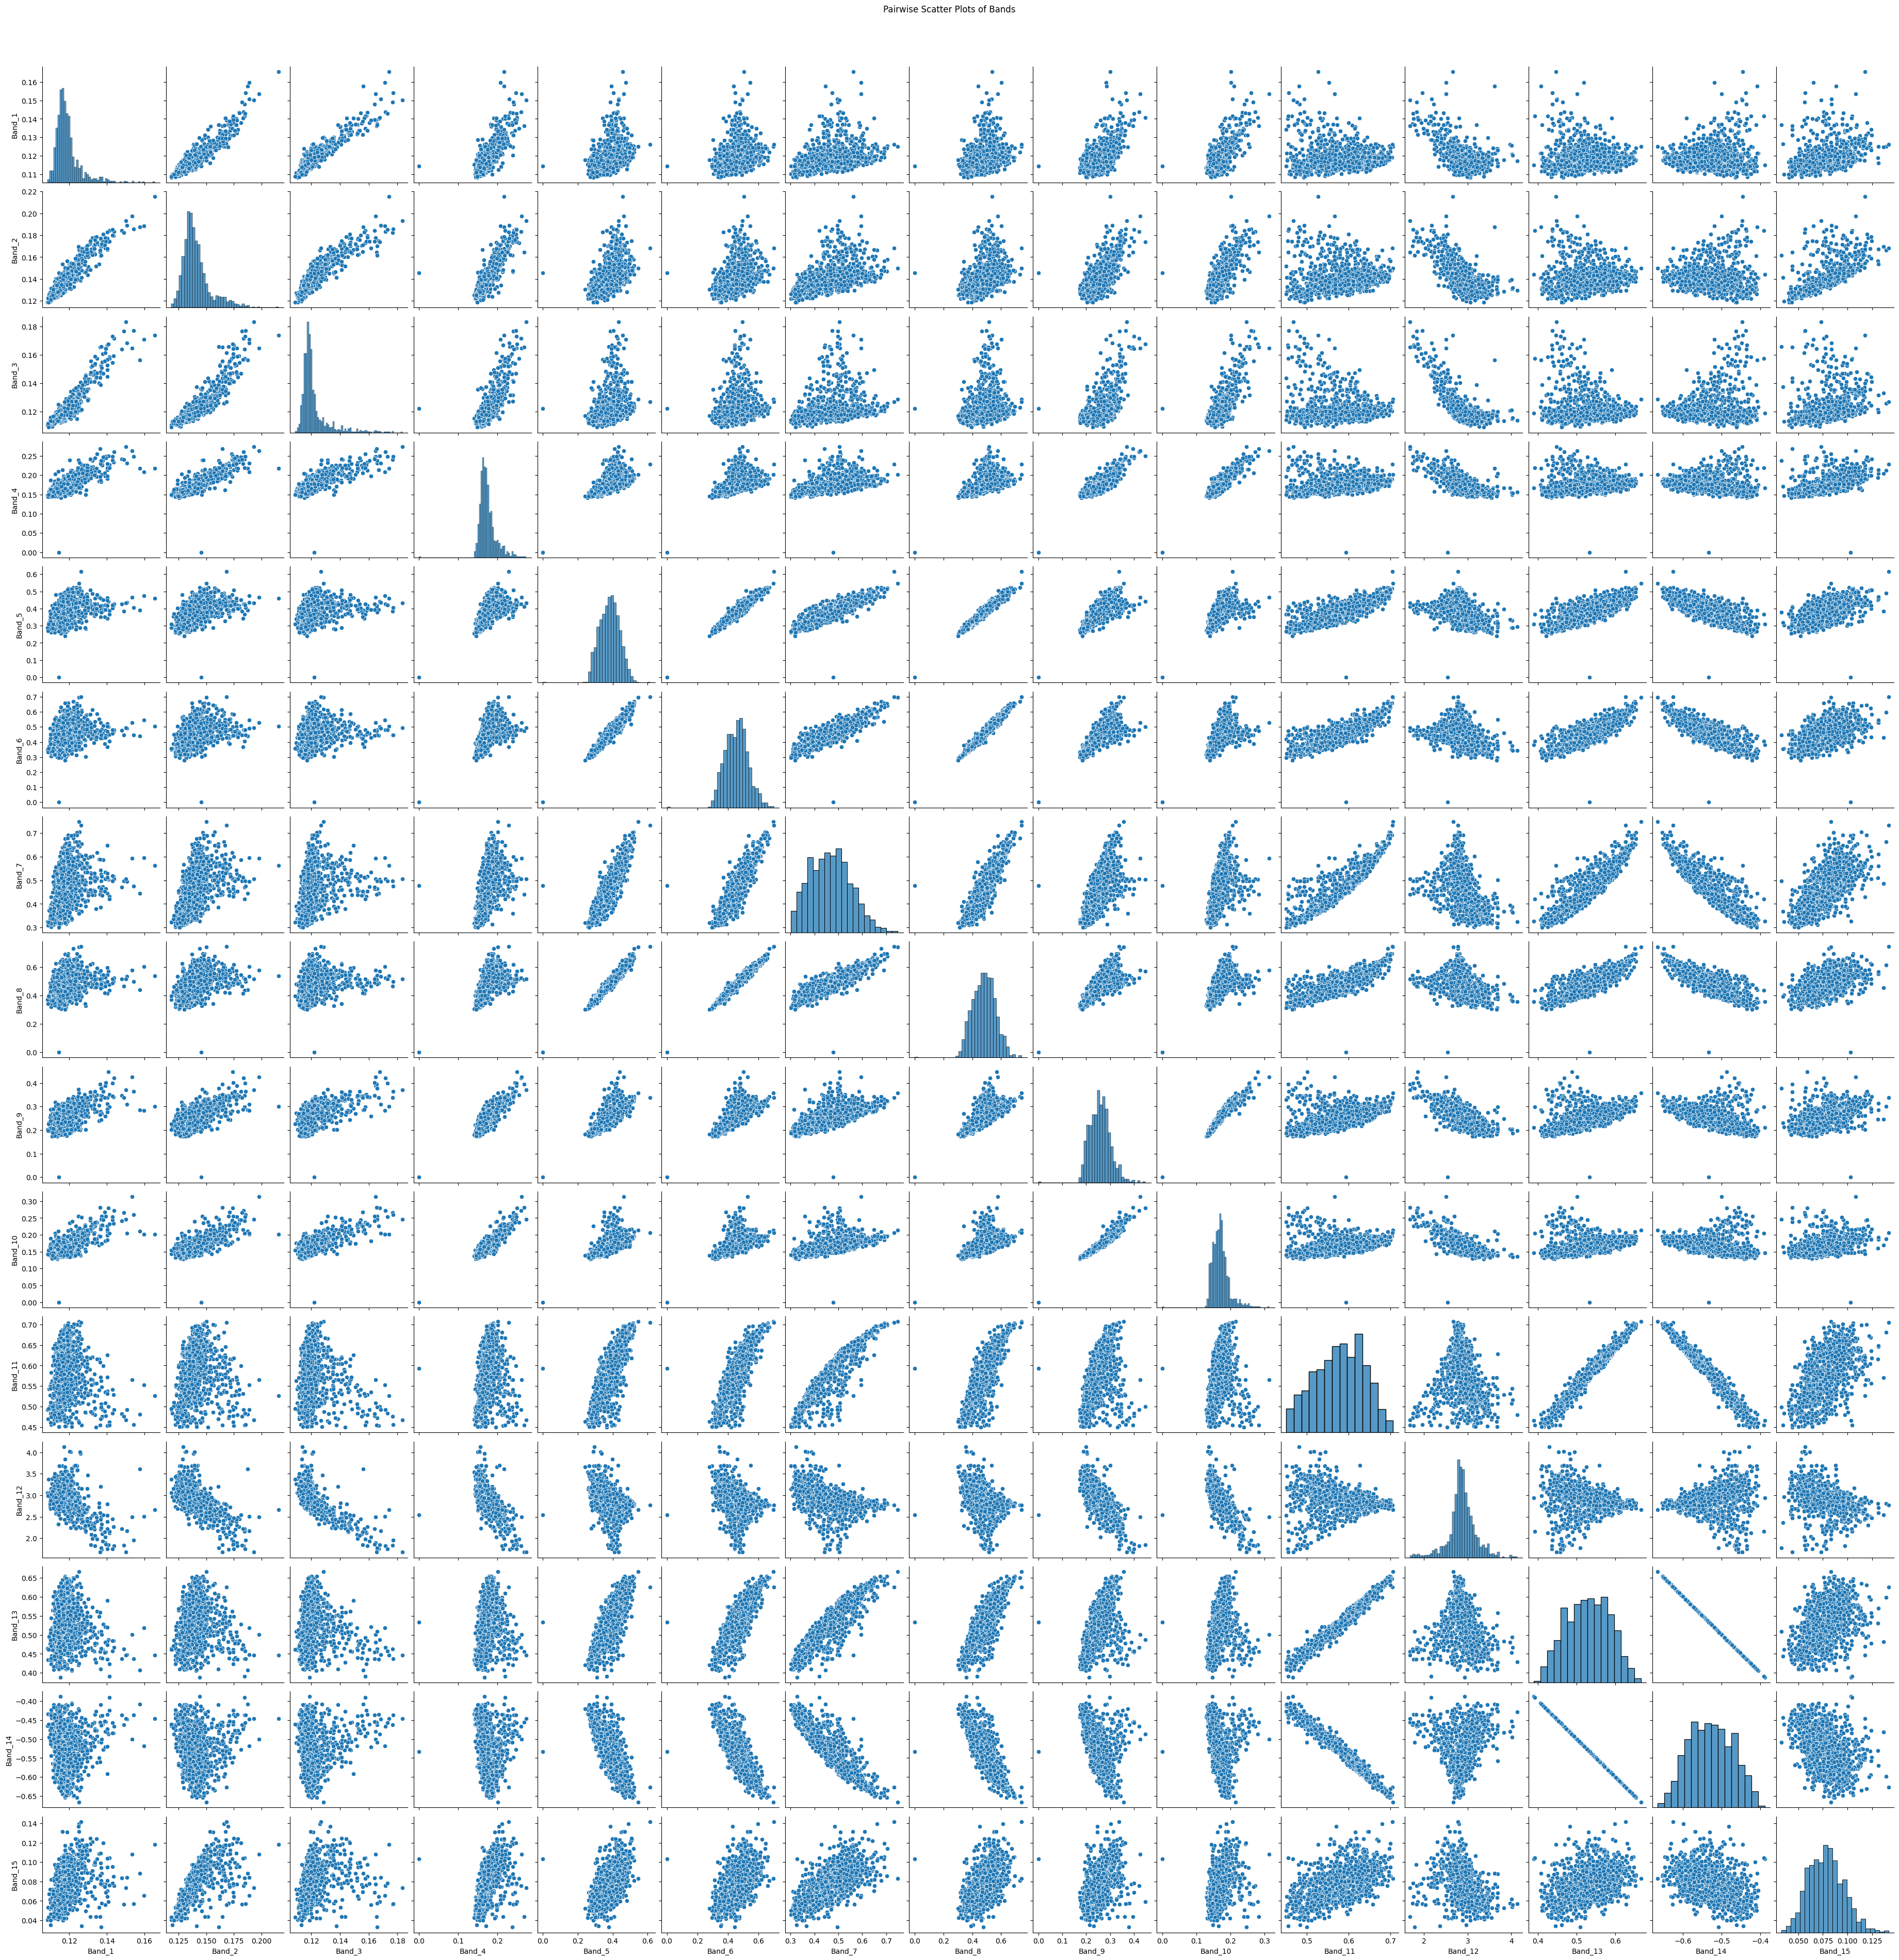

In [4]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the raster
raster = rasterio.open("/content/stacked_bands_indices.tif")
bands = [raster.read(i + 1).astype(float) for i in range(raster.count)]

# Stack bands into a 2D array (pixels × bands)
stacked = np.stack(bands, axis=-1)  # shape: (height, width, bands)
flat = stacked.reshape(-1, raster.count)  # Flatten to (num_pixels, num_bands)

# Remove rows with NaNs (e.g., from nodata pixels)
flat = flat[~np.isnan(flat).any(axis=1)]

# Create DataFrame for plotting
band_names = [f'Band_{i+1}' for i in range(raster.count)]
df = pd.DataFrame(flat, columns=band_names)

# Correlation matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Band Correlation Matrix")
plt.show()

# Pairwise scatter plots
sns.pairplot(df.sample(1000))  # Sample 1000 pixels to keep the plot readable
plt.suptitle("Pairwise Scatter Plots of Bands", y=1.02)
plt.show()

In [11]:
import geopandas as gpd

# Read extracted KML
points = gpd.read_file("/content/sampled_points_new.shp", driver='ESRI Shapefile')

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DRIVER
  return ogr_read(


In [12]:
points['spicies'].value_counts()

spicies
Coniferous forest    4500
Beech forest         1590
Oak forest            540
Broadleaf forest      450
Mixed forest           30
Name: count, dtype: int64

In [13]:
from rasterio import sample

# Reproject points to raster CRS
points = points.to_crs(raster.crs)

# Extract spectral values
coords = [(pt.x, pt.y) for pt in points.geometry]

samples = np.array(list(raster.sample(coords)))  # Now it's a NumPy array
X = samples[:, [7,8,6,2,14]]  # Select bands 8, 9, 7, and 3 (0-based)

y = points["spicies"].values  # Target

Accuracy: 0.7658227848101266


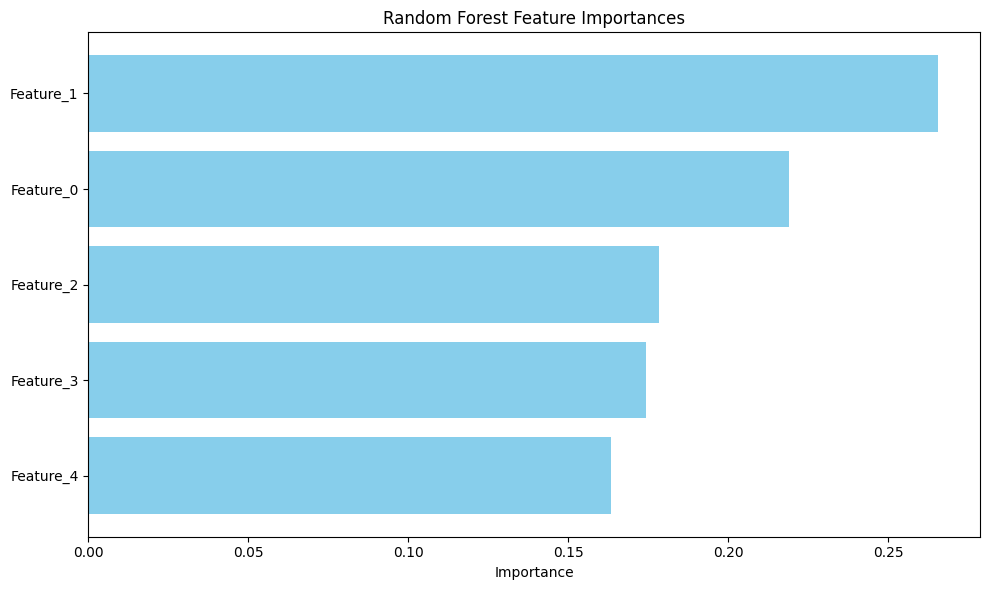

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming you have X (features) and y (labels) already
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
print("Accuracy:", rf.score(X_test, y_test))

# === Feature importance ===
importances = rf.feature_importances_
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature_{i}' for i in range(X.shape[1])]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()

# Hyper-parameter Tunning

[I 2025-06-06 11:51:30,362] A new study created in memory with name: no-name-e2a4c8d9-8388-49f2-a821-8f5bec596309
[I 2025-06-06 11:51:35,287] Trial 0 finished with value: 0.7260900140646976 and parameters: {'n_estimators': 257, 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 0 with value: 0.7260900140646976.
[I 2025-06-06 11:51:37,320] Trial 1 finished with value: 0.7206399437412095 and parameters: {'n_estimators': 111, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7260900140646976.
[I 2025-06-06 11:51:40,085] Trial 2 finished with value: 0.7283755274261603 and parameters: {'n_estimators': 140, 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 2 with value: 0.7283755274261603.
[I 2025-06-06 11:51:44,017] Trial 3 finished with value: 0.7364627285513361 and parameters: {'n_estimators': 153, 'max_depth': 

Best parameters: {'n_estimators': 55, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}
Best cross-validation accuracy: 0.7543952180028128
Test accuracy: 0.7693389592123769


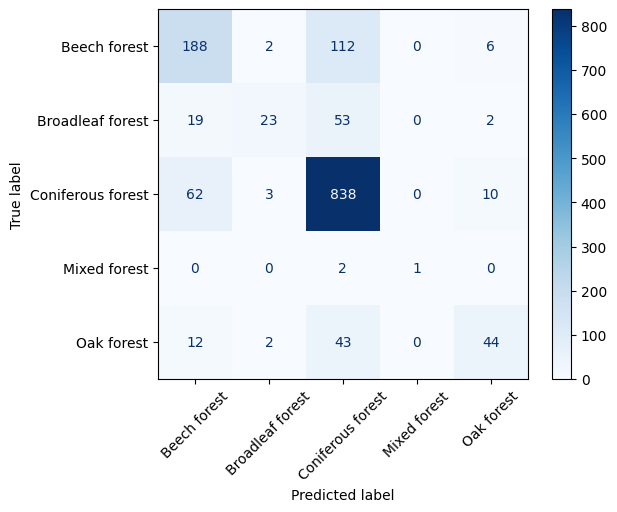

In [15]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and points["Name"] are defined
y = points["spicies"].values  # Target with class names

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    clf = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)

# Train the best model on the full training set
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate on test set
print("Test accuracy:", best_rf.score(X_test, y_test))

# Predict and show confusion matrix
y_pred = best_rf.predict(X_test)
class_names = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Stack and reshape raster bands
image_stack = np.dstack(bands)
nrows, ncols, nbands = image_stack.shape
flat_pixels = image_stack.reshape(nrows * ncols, nbands)

# Predict
predicted = rf.predict(flat_pixels)

# Reshape to image
classified = predicted.reshape(nrows, ncols)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode string labels into integers
le = LabelEncoder()
classified_encoded = le.fit_transform(classified.ravel()).reshape(classified.shape)

# Save the numeric raster
with rasterio.open(
    "classified.tif",
    "w",
    driver="GTiff",
    height=classified.shape[0],
    width=classified.shape[1],
    count=1,
    dtype=rasterio.uint8,
    crs=raster.crs,
    transform=raster.transform,
) as dst:
    dst.write(classified_encoded.astype(rasterio.uint8), 1)

# Save label mapping to decode later
np.save("class_names.npy", le.classes_)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]'), 'transform': Affine(10.0, 0.0, 440400.0,
       0.0, -10.0, 5402360.0)}


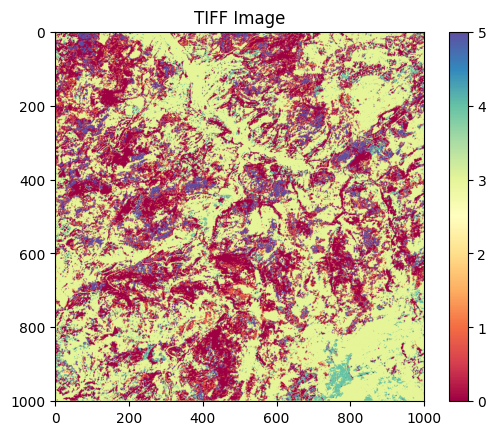

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Path to your TIFF file
tiff_path = '/content/classified.tif'

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    # Read the raster data (assuming single band)
    image = src.read(1)

    # Optional: get some metadata
    print(src.meta)

# Display the image using matplotlib
plt.imshow(image, cmap='Spectral')
plt.colorbar()
plt.title('TIFF Image')
plt.show()


Loading data...
Class distribution after filtering:
label
Coniferous forest    1347
Beech forest          529
Oak forest            180
Broadleaf forest      150
Mixed forest           10
Name: count, dtype: int64

Classification Report:
                   precision    recall  f1-score   support

     Beech forest       0.69      0.57      0.63       159
 Broadleaf forest       1.00      0.09      0.16        45
Coniferous forest       0.74      0.92      0.82       404
     Mixed forest       0.00      0.00      0.00         3
       Oak forest       0.67      0.37      0.48        54

         accuracy                           0.73       665
        macro avg       0.62      0.39      0.42       665
     weighted avg       0.74      0.73      0.70       665


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


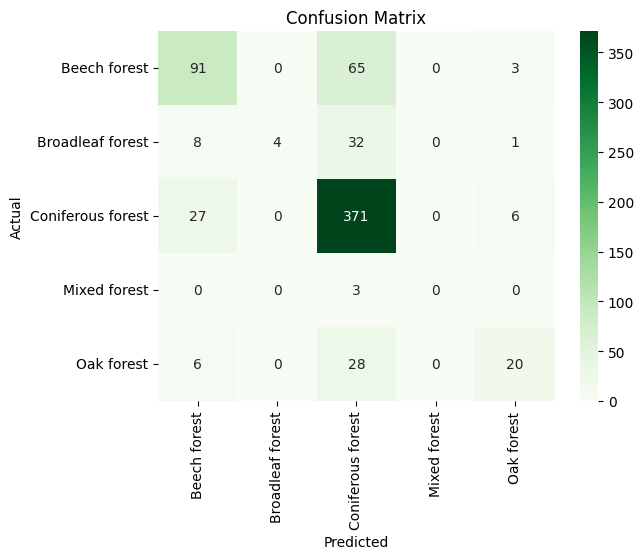

In [17]:
import geopandas as gpd
import rasterio
import rasterio.sample
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
# -----------------------------
RASTER_PATH = "/content/stacked_bands_indices.tif"
SHAPEFILE_PATH = "/content/generated_points.shp"
LABEL_COLUMN = "spicies"  # column in shapefile with tree species label
MIN_PIXELS_PER_CLASS = 5
USE_CLASS_WEIGHT = True
RANDOM_STATE = 42

# -----------------------------
# Step 1: Load raster and shapefile
# -----------------------------
print("Loading data...")
raster = rasterio.open(RASTER_PATH)
gdf = gpd.read_file(SHAPEFILE_PATH)
gdf = gdf.to_crs(raster.crs)  # reproject points to raster CRS

# -----------------------------
# Step 2: Extract raster values at point locations
# -----------------------------
coords = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
raster_values = np.array(list(raster.sample(coords)))

# Combine raster values and labels
df = pd.DataFrame(raster_values, columns=[f'B{i+1}' for i in range(raster.count)])
df['label'] = gdf[LABEL_COLUMN].values

# Drop any rows with missing values
df = df.dropna()

# -----------------------------
# Step 3: Filter low-sample classes
# -----------------------------
class_counts = df['label'].value_counts()
valid_classes = class_counts[class_counts >= MIN_PIXELS_PER_CLASS].index
df = df[df['label'].isin(valid_classes)]

print("Class distribution after filtering:")
print(df['label'].value_counts())

# -----------------------------
# Step 4: Balance classes (optional)
# -----------------------------
X = df.drop(columns=['label'])
y = df['label']

if not USE_CLASS_WEIGHT:
    df_balanced = pd.DataFrame()
    min_count = df['label'].value_counts().min()
    for label in valid_classes:
        subset = df[df['label'] == label]
        balanced = resample(subset, n_samples=min(min_count, len(subset)), random_state=RANDOM_STATE)
        df_balanced = pd.concat([df_balanced, balanced])
    X = df_balanced.drop(columns=['label'])
    y = df_balanced['label']

# -----------------------------
# Step 5: Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=RANDOM_STATE
)

# -----------------------------
# Step 6: Train Random Forest
# -----------------------------
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced' if USE_CLASS_WEIGHT else None,
    random_state=RANDOM_STATE
)
clf.fit(X_train, y_train)

# -----------------------------
# Step 7: Evaluate model
# -----------------------------
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()